In [48]:
from nltk import ngrams
import math 
import string 
import re

import json 

import pandas as pd 
import sqlite3
import requests 
import bs4 
import query_config as query_config

# sentence = 'this is a foo bar sentences and I want to ngramize it'

# n = 6
# sixgrams = ngrams(sentence.split(), n)

# for grams in sixgrams:
#   print(grams)

In [49]:

def connect_to_db(db_path):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    return conn, c 

In [50]:
def read_db(db_path):
    parent_path = '/home/ramprasad.sa'
    db_path = f'{parent_path}/{db_path}'
    conn, c = connect_to_db(db_path)
    df_annotations = pd.read_sql('SELECT * from label', conn)
    return df_annotations

In [51]:

db_path = 'human_annotations_factuality/billsum/set1/annotated/billsum_summaries_set1.db'

df_annotations = read_db(db_path)
df_annotations.head()

,uuid,user_id,summary_uuid,summ_id,system_id,label_type,summary,nonfactual_sentences,article
0,1,sanjana,044200e5-f15a-44e2-a77a-e850e8792891_flant5_gen,billsum_generic,flant5,factual,Veterans Back and Spinal Therapy Act,,SECTION 1. SHORT TITLE.\r\n\r\n This Act ma...
1,2,sanjana,044200e5-f15a-44e2-a77a-e850e8792891_gpt3_gen,billsum_generic,gpt3,factual,"The ""Veterans Back and Spinal Therapy Act"" is ...",,SECTION 1. SHORT TITLE.\r\n\r\n This Act ma...
2,3,sanjana,09484b42-bbf4-4225-906e-d88653ca5c72_flant5_gen,billsum_generic,flant5,factual,"To amend the Federal Food, Drug, and Cosmetic ...",,SECTION 1. SHORT TITLE.\r\n This Act may be...
3,4,sanjana,09484b42-bbf4-4225-906e-d88653ca5c72_gpt3_gen,billsum_generic,gpt3,factual,The Improving Regulatory Transparency for New ...,,SECTION 1. SHORT TITLE.\r\n This Act may be...
4,5,sanjana,0dbcdcc5-7e3d-47aa-9c03-aea7a6734246_flant5_gen,billsum_generic,flant5,factual,A bill to establish the Oil Region National He...,,SECTION 1. SHORT TITLE; DEFINITIONS.\r\n\r\n ...


In [68]:
from scipy import stats
def get_copy_scores(df_annotations):
    unique_models = list(set(df_annotations['model']))
    for model in unique_models:
        df_annotations_model = df_annotations[df_annotations['model'] == model]
        three_gram_overlaps = []
        four_gram_overlaps = []
        five_gram_overlaps = []
        non_factual_sents_scores = df_annotations_model['non_factual_sents'].values
        for idx, row in df_annotations_model.iterrows():
            doc = row['article']
            summary = row['summary']
    
            for n in range(3,6):
                doc_ngrams = [each for each in ngrams(doc.split(), n)]
                summary_ngrams = [each for each in ngrams(summary.split(), n)]
                # print(summary_ngrams)
                n_overlap_perc = 0
                if summary_ngrams:
                    n_overlap_perc = len(set(doc_ngrams).intersection(set(summary_ngrams)))/len(set(summary_ngrams))
                if n == 3:
                    three_gram_overlaps.append(n_overlap_perc)
                elif n == 4:
                    four_gram_overlaps.append(n_overlap_perc)
                else:
                    five_gram_overlaps.append(n_overlap_perc)
        print(len(three_gram_overlaps), len(non_factual_sents_scores))
        print('MODEL: ', model)
        print('THREE GRAM: ', np.mean(three_gram_overlaps), stats.spearmanr(non_factual_sents_scores, three_gram_overlaps ))
        print('FOUR GRAM: ', np.mean(four_gram_overlaps), stats.spearmanr(non_factual_sents_scores, four_gram_overlaps ))
        print('FIVE GRAM: ', np.mean(five_gram_overlaps), stats.spearmanr(non_factual_sents_scores, four_gram_overlaps ))
        print('==='*13)

In [77]:
df_errors = pd.read_csv('/home/ramprasad.sa/factual_annotation_llm_summaries/analysis/notebook/error_scores_pubmed.csv')
get_copy_scores(df_errors)

50 50
MODEL:  gpt3
THREE GRAM:  0.3172436066891092 SignificanceResult(statistic=0.2305411788429308, pvalue=0.10724050601566602)
FOUR GRAM:  0.22513467986574492 SignificanceResult(statistic=0.17447113141583717, pvalue=0.22558355471834612)
FIVE GRAM:  0.16639212774477893 SignificanceResult(statistic=0.17447113141583717, pvalue=0.22558355471834612)
50 50
MODEL:  flant5
THREE GRAM:  0.6246517508780146 SignificanceResult(statistic=-0.3211204872302476, pvalue=0.022976639152992973)
FOUR GRAM:  0.5120863326895289 SignificanceResult(statistic=-0.27876959521376965, pvalue=0.04994950257917889)
FIVE GRAM:  0.4476264710220774 SignificanceResult(statistic=-0.27876959521376965, pvalue=0.04994950257917889)


In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

In [153]:
df_dict = {'copying': [0.28, 0.22, 0.42, 0.30], 'model': ['gpt3', 'gpt3', 'flant5', 'flant5'], 'domain':['news','news', 'news','news'], 
           'var': ['copy', 'inc', 'copy', 'inc']}


# df_dict = {'scores': [0.28, 0.42, 0.22, 0.30, 0.28, 0.31],
#            'domain': ['news', 'news', 'news', 'news', 'legal', 'legal'],
#            'model': ['gpt3', 'flant5', 'gpt3', 'flant5', 'gpt3', 'flant5'],
#            'var': ['copy (news)' , 'copy (news)', 'inacc (news)', 'inacc (news)', 'copy', 'copy']}
df_dict_1 = {
            'scores': [0.28, 0.42, 0.28, 0.41, 0.31, 0.62],
           'domain': ['news', 'news', 'legal', 'legal', 'biomed', 'biomed'],
           'model': ['gpt3', 'flant5', 'gpt3', 'flant5', 'gpt3', 'flant5'],
           
}

df_dict_2 = {
            'inconsistencies': [0.22, 0.30, 0.21, 0.23, 0.02, 0.06],
           'domain': ['news', 'news', 'legal', 'legal', 'biomed', 'biomed'],
           'model': ['gpt3', 'flant5', 'gpt3', 'flant5', 'gpt3', 'flant5'],
           
}
df_1 = pd.DataFrame(df_dict_1)
df_2 = pd.DataFrame(df_dict_2)
df_2

,inconsistencies,domain,model
0,0.22,news,gpt3
1,0.30,news,flant5
2,0.21,legal,gpt3
3,0.23,legal,flant5
4,0.02,biomed,gpt3
5,0.06,biomed,flant5


In [149]:
# stats.spearmanr(df_1['scores'].values, df_2['inconsistencies'].values )

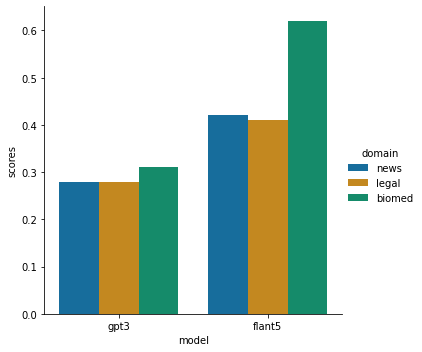

In [156]:
sns.catplot(
    data=df_1, kind="bar",
    x="model", y="scores", hue="domain",
    errorbar="sd", palette="colorblind"
)


In [122]:
hue_filter = list(df[['model', 'var']].apply(tuple, axis=1).values)
hue_filter = ['

[('gpt3', 'copy'), ('flant5', 'copy'), ('gpt3', 'inacc'), ('flant5', 'inacc')]